In [1]:
import psycopg2
import pandas as pd
import numpy as np
import statistics as sts
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
import seaborn as srn
from sklearn.preprocessing import LabelEncoder

In [2]:
conexao = psycopg2.connect(host="localhost",database="inadiplencia", user="postgres", password="Al103568545", port=5432)

In [3]:
cursor = conexao.cursor()

In [4]:
# consulta_credito = 'SELECT * FROM "CREDITO"'
consulta_credito = 'SELECT CR."Duracao", HC."HISTORICO", PR."PROPOSITO",CR."Valor", INV."INVESTIMENTOS", ' \
                   'EMP."EMPREGO",CR."TempoParcelamento", ES."ESTADOCIVIL", FT."FIADOR", CR."ResidenciaDesde",' \
                   'CR."Idade", OFC."OUTROSFINANCIAMENTOS", HAB."HABITACAO", CR."EmprestimoExistente", ' \
                   'PRO."PROFISSAO", CR."Dependentes",CR."SocioEmpresa",CR."Estrangeiro",CR."Status" FROM "CREDITO" ' \
                   'CR INNER JOIN "ESTADOCIVIL" ES ON (CR."EstadoCivil" = ES."IDESTADOCIVIL") INNER JOIN ' \
                   '"HISTORICO_CREDITO" HC ON(CR."HistoricoCredito" = HC."IDHISTCRED") INNER JOIN "PROPOSITO" PR ON (' \
                   'CR."Proposito" =  PR."IDPROPOSITO") INNER JOIN "INVESTIMENTOS" INV ON(CR."Investimentos" = ' \
                   'INV."IDINVESTIMENTOS") INNER JOIN "EMPREGO" EMP ON (CR."Emprego" = EMP."IDEMPREGO") INNER JOIN ' \
                   '"FIADOR" FT ON (CR."FiadorTerceiros" = FT."IDFIADOR") INNER JOIN "OUTROSFINANC" OFC ON (' \
                   'CR."OutrosFinanciamentos" = OFC."IDOUTROSFINANC") INNER JOIN "HABITACAO" HAB ON (CR."Habitacao" = ' \
                   'HAB."IDHABITACAO") INNER JOIN "PROFISSAO" PRO ON (CR."Profissao" = PRO."IDPROFISSAO")'
cursor.execute(consulta_credito)

In [5]:
registroCredito = cursor.fetchall()

In [6]:
pd.options.display.float_format = '{:,.2f}'.format

In [7]:
credito = pd.DataFrame(registroCredito)
credito

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,48,existentes/pagos,reforma,5951,<100\n,1<=X<4,2,feminino div/dep/cas,nao,2.00,22,nenhum,proria,1,qualificado,1,0,0,0
1,12,Critico-outros creditos,educacao,2096,<100\n,4<=X<7,2,masculino solteiro,nao,3.00,49,nenhum,proria,1,nao qualificado,2,0,0,1
2,42,existentes/pagos,moveis,7882,<100\n,4<=X<7,2,masculino solteiro,sim,4.00,45,nenhum,de graca,1,qualificado,2,0,0,1
3,24,Atrasos anteriores,veiculo novo,4870,<100\n,1<=X<4,3,masculino solteiro,nao,4.00,53,nenhum,de graca,2,qualificado,2,0,0,0
4,36,existentes/pagos,educacao,9055,Desconhecido\n,1<=X<4,2,masculino solteiro,nao,4.00,35,nenhum,de graca,1,nao qualificado,2,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
961,15,existentes/pagos,veiculo novo,1403,<100\n,1<=X<4,2,feminino div/dep/cas,nao,NaN,28,nenhum,alugada,1,qualificado,1,0,0,1
962,18,Atrasos anteriores,moveis,4297,<100\n,>=7,4,maculino div/dep,nao,NaN,40,nenhum,proria,1,altamente qualificado/empresario,1,1,0,0
963,36,existentes/pagos,educacao,1977,Desconhecido\n,>=7,4,masculino solteiro,nao,NaN,40,nenhum,proria,1,altamente qualificado/empresario,1,1,0,0
964,9,Critico-outros creditos,educacao,1136,>=1000,>=7,4,masculino solteiro,nao,NaN,32,nenhum,de graca,2,qualificado,2,0,0,0


In [8]:
credito.columns = ["duracao", "historico_credito", "proposito", "valor", "investimentos", 
                   "emprego", "tempo_parcelamento", "estado_civil", "fiador_terceiros", "residencia", 
                   "idade", "outros_financiamentos", "habitacao", "emprestimo_existente", 
                   "profissao", "dependentes", "socio_empresa", "estrangeiro", "status"]
credito.head()

,duracao,historico_credito,proposito,valor,investimentos,emprego,tempo_parcelamento,estado_civil,fiador_terceiros,residencia,idade,outros_financiamentos,habitacao,emprestimo_existente,profissao,dependentes,socio_empresa,estrangeiro,status
0,48,existentes/pagos,reforma,5951,<100\n,1<=X<4,2,feminino div/dep/cas,nao,2.00,22,nenhum,proria,1,qualificado,1,0,0,0
1,12,Critico-outros creditos,educacao,2096,<100\n,4<=X<7,2,masculino solteiro,nao,3.00,49,nenhum,proria,1,nao qualificado,2,0,0,1
2,42,existentes/pagos,moveis,7882,<100\n,4<=X<7,2,masculino solteiro,sim,4.00,45,nenhum,de graca,1,qualificado,2,0,0,1
3,24,Atrasos anteriores,veiculo novo,4870,<100\n,1<=X<4,3,masculino solteiro,nao,4.00,53,nenhum,de graca,2,qualificado,2,0,0,0
4,36,existentes/pagos,educacao,9055,Desconhecido\n,1<=X<4,2,masculino solteiro,nao,4.00,35,nenhum,de graca,1,nao qualificado,2,1,0,1


# Análise, exploração de dados e exclusão de junkdata  

In [9]:
credito.drop(["investimentos", "emprego", "residencia"], axis=1, inplace=True)

In [10]:
credito.isna().values.sum()

0

Text(0.5, 1.0, 'valor')

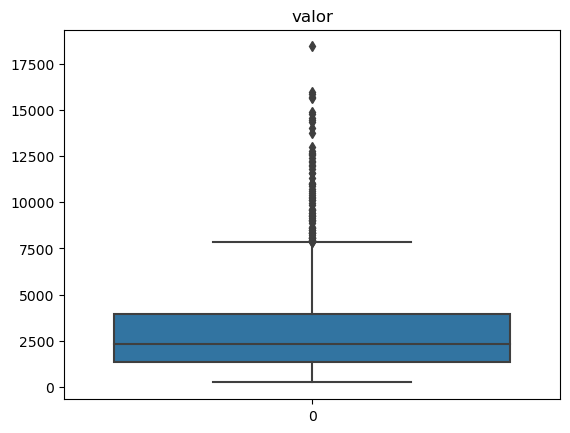

In [11]:
srn.boxplot(credito['valor']).set_title('valor')

In [12]:
credito.valor = np.log(credito.valor)

<AxesSubplot:xlabel='valor', ylabel='Count'>

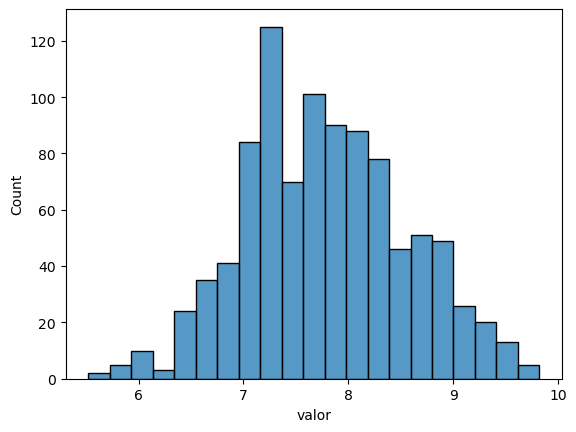

In [13]:
srn.histplot(x=credito.valor)

In [14]:
estado_civil = credito.groupby(["estado_civil"]).size()
estado_civil

estado_civil
feminino div/dep/cas    301
maculino div/dep         50
masculino cas/viu        88
masculino solteiro      527
dtype: int64

<AxesSubplot:>

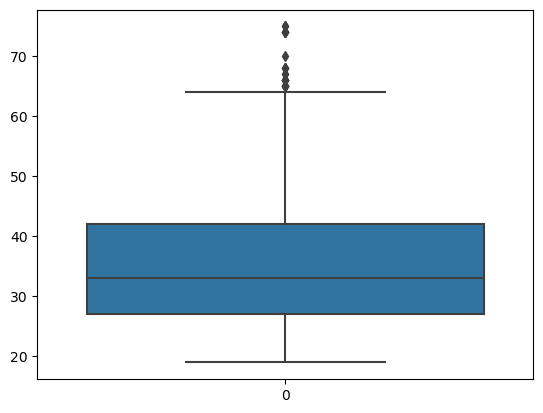

In [15]:
srn.boxplot(credito["idade"])

In [16]:
credito.idade.describe()

count   966.00
mean     35.52
std      11.37
min      19.00
25%      27.00
50%      33.00
75%      42.00
max      75.00
Name: idade, dtype: float64

<AxesSubplot:>

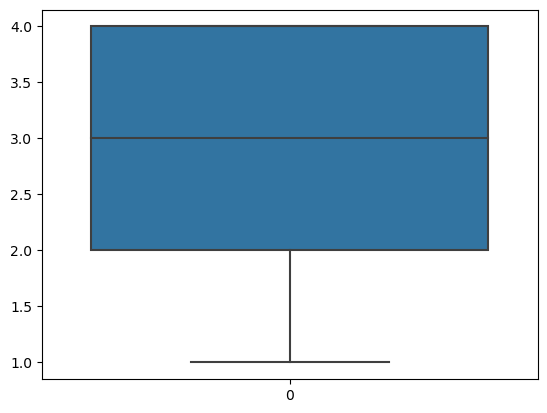

In [17]:
srn.boxplot(credito["tempo_parcelamento"])

<AxesSubplot:>

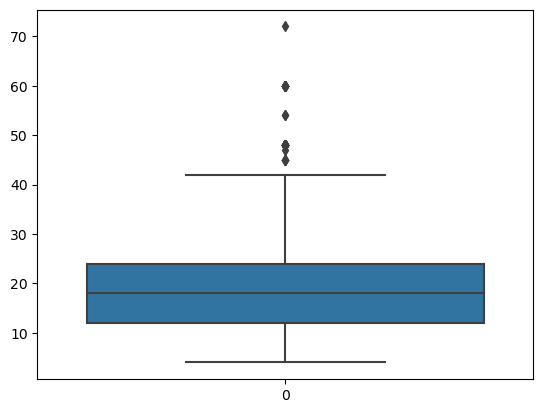

In [18]:
srn.boxplot(credito["duracao"])

In [19]:
credito.duracao.describe()

count   966.00
mean     20.81
std      12.08
min       4.00
25%      12.00
50%      18.00
75%      24.00
max      72.00
Name: duracao, dtype: float64

In [20]:
historico_credito = credito.groupby(["historico_credito"]).size()
historico_credito

historico_credito
Atrasos anteriores           83
Critico-outros creditos     285
existentes/pagos            511
sem creditos/todos pagos     40
todos pagos                  47
dtype: int64

In [21]:
proposito = credito.groupby(credito["proposito"]).size()
proposito

proposito
abrir negocio     94
educacao          48
moveis           175
outros            12
qualificacao       8
quitar divida     12
reforma          270
reforma casa      22
veiculo novo     228
veiculo usado     97
dtype: int64

In [22]:
fiador_terceiros = credito.groupby(credito["fiador_terceiros"]).size()
fiador_terceiros

fiador_terceiros
co aplicante       1
co requerente     39
nao              879
sim               47
dtype: int64

In [23]:
outros_financiamentos = credito.groupby(credito["outros_financiamentos"]).size()
outros_financiamentos

outros_financiamentos
banco     136
loja       42
nenhum    788
dtype: int64

In [24]:
habitacao = credito.groupby(credito["habitacao"]).size()
habitacao

habitacao
alugada     172
de graca    104
proria      690
dtype: int64

In [25]:
credito.emprestimo_existente.describe()

count   966.00
mean      1.41
std       0.58
min       1.00
25%       1.00
50%       1.00
75%       2.00
max       4.00
Name: emprestimo_existente, dtype: float64

<AxesSubplot:>

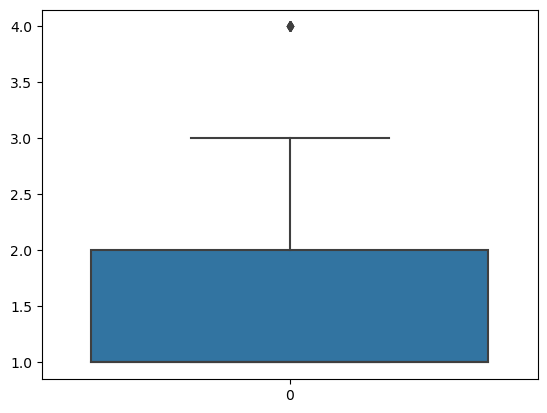

In [26]:
srn.boxplot(credito["emprestimo_existente"])

In [27]:
credito.emprestimo_existente.describe()

count   966.00
mean      1.41
std       0.58
min       1.00
25%       1.00
50%       1.00
75%       2.00
max       4.00
Name: emprestimo_existente, dtype: float64

In [28]:
agrupado_credito = credito.groupby(credito["profissao"]).size()
agrupado_credito

profissao
altamente qualificado/empresario    139
desempregado                         22
nao qualificado                     194
qualificado                         611
dtype: int64

In [29]:
dependentes = credito.groupby(credito["dependentes"]).size()
dependentes

dependentes
1    814
2    152
dtype: int64

# Padronização para o modelo e Modelo funcionando
Aproximadamente 75% de accuracy utilizando Random Forest

In [30]:
X = credito.iloc[:,0:15].values
y = credito.iloc[:,15].values


In [31]:
labelencoder = LabelEncoder()
X[:,1] = labelencoder.fit_transform(X[:,1])
X[:,2] = labelencoder.fit_transform(X[:,2])
X[:,5] = labelencoder.fit_transform(X[:,5])
X[:,6] = labelencoder.fit_transform(X[:,6])
X[:,8] = labelencoder.fit_transform(X[:,8])
X[:,9] = labelencoder.fit_transform(X[:,9])
X[:,11] = labelencoder.fit_transform(X[:,11])


In [32]:
X_treinamento, X_teste, y_treinamento, y_teste = train_test_split(X,
                                                                  y,
                                                                  test_size = 0.2,
                                                                  random_state = 0)


In [33]:
floresta = RandomForestClassifier(n_estimators=20000)
floresta.fit(X_treinamento, y_treinamento)

RandomForestClassifier(n_estimators=20000)

In [42]:
previsoes = floresta.predict(X_teste)
confusao = confusion_matrix(y_teste, previsoes)
taxa_acerto = accuracy_score(y_teste, previsoes) 
accurancy = taxa_acerto*100

print(f"Taxa de acerto: {accurancy:.3}%")

Taxa de acerto: 75.8%


In [35]:
for i in range(len(X_teste)):
    print("Entrada:", y_teste[i], "Previsão:", previsoes[i])

Entrada: 1 Previsão: 0
Entrada: 1 Previsão: 1
Entrada: 1 Previsão: 1
Entrada: 1 Previsão: 1
Entrada: 0 Previsão: 0
Entrada: 0 Previsão: 1
Entrada: 1 Previsão: 1
Entrada: 0 Previsão: 1
Entrada: 1 Previsão: 1
Entrada: 1 Previsão: 1
Entrada: 0 Previsão: 1
Entrada: 1 Previsão: 1
Entrada: 1 Previsão: 1
Entrada: 0 Previsão: 0
Entrada: 1 Previsão: 1
Entrada: 0 Previsão: 0
Entrada: 1 Previsão: 1
Entrada: 0 Previsão: 1
Entrada: 0 Previsão: 1
Entrada: 1 Previsão: 1
Entrada: 0 Previsão: 0
Entrada: 1 Previsão: 1
Entrada: 1 Previsão: 0
Entrada: 1 Previsão: 1
Entrada: 0 Previsão: 1
Entrada: 1 Previsão: 1
Entrada: 1 Previsão: 1
Entrada: 1 Previsão: 1
Entrada: 0 Previsão: 1
Entrada: 0 Previsão: 1
Entrada: 0 Previsão: 1
Entrada: 0 Previsão: 0
Entrada: 1 Previsão: 1
Entrada: 1 Previsão: 1
Entrada: 0 Previsão: 1
Entrada: 0 Previsão: 1
Entrada: 0 Previsão: 1
Entrada: 0 Previsão: 1
Entrada: 0 Previsão: 0
Entrada: 1 Previsão: 1
Entrada: 1 Previsão: 1
Entrada: 0 Previsão: 1
Entrada: 1 Previsão: 1
Entrada: 1 

Usando para fazer previsões de dados inéditos para o modelo

In [36]:
novos_dados = pd.read_csv('novos_dados.csv',sep=";")
novos_dados.head()

,duracao,historico_credito,proposito,valor,tempo_parcelamento,estado_civil,fiador_terceiros,idade,outros_financiamentos,habitacao,emprestimo_existente,profissao,dependentes,socio_empresa,estrangeiro
0,48,existentes/pagos,reforma,5851,2,feminino div/dep/cas,nao,22,nenhum,propria,1,qualificado,1,0,0
1,24,sem creditos/todos pagos,veiculo usado,25000,4,masculino solteiro,sim,18,banco,de graca,1,qualificado,2,0,0
2,5,existentes/pagos,reforma,2000,1,masculino cas/viu,sim,34,nenhum,propria,2,altamente qualificado/empresario\t,1,1,0


In [37]:
novos_dados.valor = np.log(novos_dados.valor)
novos_dados = novos_dados.iloc[:, 0:15].values
novos_dados[:, 1] = labelencoder.fit_transform(novos_dados[:, 1])
novos_dados[:, 2] = labelencoder.fit_transform(novos_dados[:, 2])
novos_dados[:, 5] = labelencoder.fit_transform(novos_dados[:, 5])
novos_dados[:, 6] = labelencoder.fit_transform(novos_dados[:, 6])
novos_dados[:, 8] = labelencoder.fit_transform(novos_dados[:, 8])
novos_dados[:, 9] = labelencoder.fit_transform(novos_dados[:, 9])
novos_dados[:, 11] = labelencoder.fit_transform(novos_dados[:, 11])


In [38]:
floresta.predict(novos_dados)

array([0, 0, 1], dtype=int64)